In [2]:
import pandas as pd
import numpy as np
import math
from datetime import timedelta
import matplotlib.pyplot as plt
import pyentrp.entropy as ent
from scipy.optimize import curve_fit
import statsmodels.api as sm
from matplotlib.lines import Line2D

In [3]:
# Reading the synthetic rooftop PV dataset and site details file associated with it
# (Note that the results produced using the dummy dataset are likely to be different with the ones
# shown in the research article)

input_df = pd.read_csv("Input_data/synthetic_rooftop_data.gz", compression='gzip')
input_df.index = pd.to_datetime(input_df["t_stamp_utc"])
input_df = input_df.drop(columns=["t_stamp_utc"])
site_details_df = pd.read_csv("Input_data/site_details.csv", index_col=0)
all_sites = site_details_df.index

In [3]:
# Reading GTI data of 6 solar farms from the downloaded csv files
# (researchers can download the 5-min solar irradiance data for free from Solcast.com)

# The longitude and latitude data of solar farms, which are also used to gather the data from Solcast:
solarfarm_dict = {'Moree': (-29.561221, 149.86253), 'Manildra': (-33.195354, 148.684258),
                  'Griffith': (-34.313682, 146.114368), 'Coleambally': (-34.742722, 145.956064),
                  'MuggaLane': (-35.399702, 149.146995), 'Royalla': (-35.491423, 149.143369)}

solarfarm_rawdata_dict = dict()
for name in solarfarm_dict.keys():
    solarfarm_rawdata_dict[name] = pd.read_csv("Input_data/" + str(solarfarm_dict[name][0]) + '_'
                                               + str(solarfarm_dict[name][1]) + "_Solcast_PT5M.csv")
    solarfarm_rawdata_dict[name].index = solarfarm_rawdata_dict[name]['PeriodStart']
    solarfarm_rawdata_dict[name].index = pd.to_datetime(solarfarm_rawdata_dict[name].index)

In [4]:
# Calculating the average and wpe of the solar farms' GTI data

sol_df = pd.DataFrame()
parameter = 'GtiTracking'
sol_df['Name']= ['Moree', 'Manildra', 'Griffith', 'Coleambally', 'MuggaLane', 'Royalla']

# The solar farms' capacity is collected from AEMO. URL:
# https://aemo.com.au/-/media/files/electricity/nem/participant_information/nem-registration-and-exemption-list.xlsx
sol_df['Capacity']= [56, 46, 27, 150, 12, 20]

for ind in sol_df.index:
    sol_df.loc[ind, 'WPE_of_' + parameter] = ent.weighted_permutation_entropy(
        solarfarm_rawdata_dict[sol_df['Name'][ind]][parameter].resample('10min').mean(), order=6, delay=1, normalize=True)
    sol_df.loc[ind, 'AVG_of_' + parameter] = (sum(solarfarm_rawdata_dict[sol_df['Name'][ind]][parameter])/
                                              len(solarfarm_rawdata_dict[sol_df['Name'][ind]][parameter]))

In [8]:
# Calculating the WPE of the GTI data of solar farm over 2 months (60 days) rolling windows
# (the average WPE of all farms is determined based on a weighted average of their capacity)

sol_wpe_two_month_ma = pd.DataFrame()

for ind in sol_df.index:
    for month_num in list(range(0,11)):
        sol_wpe_two_month_ma.loc[ind, month_num] = (ent.weighted_permutation_entropy(
            solarfarm_rawdata_dict[sol_df['Name'][ind]]['GtiTracking'].iloc[(month_num*30*24*12):
            ((month_num+2)*30*24*12)].resample('10min').sum(), order=6, delay=1, normalize=True))

weighted_solarfarm_wpe_ma = sol_wpe_two_month_ma.mul(sol_df['Capacity'], axis=0).sum(0)/sum(sol_df['Capacity'])

In [ ]:
# Reading and processing the WPE over time data of the rooftop PV systems in NSW

rooftop_wpe_overtime = pd.read_pickle("Processed_data/WPE_over_one_Year_windows_of60days_6_10min.pkl")
wpe_rooftop_df = rooftop_wpe_overtime.copy()
Mcounter = 0
selected_state = 'NSW'

for site in rooftop_wpe_overtime.columns:
    wpe_rooftop_df[site] = 1 - wpe_rooftop_df[site]
    if not site in site_details_df[site_details_df['state'] == selected_state].index:
        wpe_rooftop_df = wpe_rooftop_df.drop(columns=[site])

In [6]:
# Reading and processing the CPF data of solar farms (the pickle files of the CPF is created based on
# the public AEMO data available at https://aemo.com.au/en/energy-systems/electricity/national-electricity-market-nem/
# system-operations/ancillary-services/ancillary-services-causer-pays-contribution-factors

cpf_df = pd.read_pickle("Input_data/CPF_Solar_NSW_2019.pkl")

# moving average of the mean CPF of all solar farms:
mean_cpf_ma = (cpf_df.mean(axis=1)).rolling(2, min_periods=1).mean()

# moving average of the normalised CPF of solar farms:
norm_cpf_df = cpf_df.div(cpf_df.max(axis=0), axis=1)
cpf_df_ma = norm_cpf_df.rolling(2, min_periods=1).mean()

cpf_df_ma.rename(columns={'Manildra Prop Pty Ltd As The Trustee For The Manildra Asset Trust': 'Manildra Solar Farm',
                          'Mugga Lane Solar Park Pty Ltd': 'Mugga Lane Solar Park',
                          'Coleambally Solar Pty Ltd': 'Coleambally Solar Farm',
                          'Moree Solar Farm Pty Ltd': 'Moree Solar Farm'}, inplace=True)

# average CPF of each solar farm:
sol_df.loc[0, 'avg_CPF'] = cpf_df.mean(axis=0)['Moree Solar Farm Pty Ltd']
sol_df.loc[1, 'avg_CPF'] = cpf_df.mean(axis=0)['Manildra Prop Pty Ltd As The Trustee For The Manildra Asset Trust']
sol_df.loc[2, 'avg_CPF'] = cpf_df.mean(axis=0)['Griffith Solar Farm Pty Ltd']
sol_df.loc[3, 'avg_CPF'] = cpf_df.mean(axis=0)['Coleambally Solar Pty Ltd']
sol_df.loc[4, 'avg_CPF'] = cpf_df.mean(axis=0)['Mugga Lane Solar Park Pty Ltd']
sol_df.loc[5, 'avg_CPF'] = cpf_df.mean(axis=0)['Royalla Solar Farm Pty Limited']

# normalised average of CPFs of solar farms:
for ind in sol_df.index:
    sol_df.loc[ind, 'norm_avg_CPF'] = sum(sol_df['Capacity'])*(sol_df.loc[ind, 'avg_CPF'])/(
            sol_df.loc[ind, 'Capacity']*len(sol_df.index))

C:\Users\a1792406\AppData\Local\Temp/ipykernel_23300/3995692189.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.axes.xaxis.set_ticklabels(['Mar-19', '', 'May-19', '', 'Jul-19', '', 'Sep-19', '', 'Nov-19', '', 'Jan-20'])


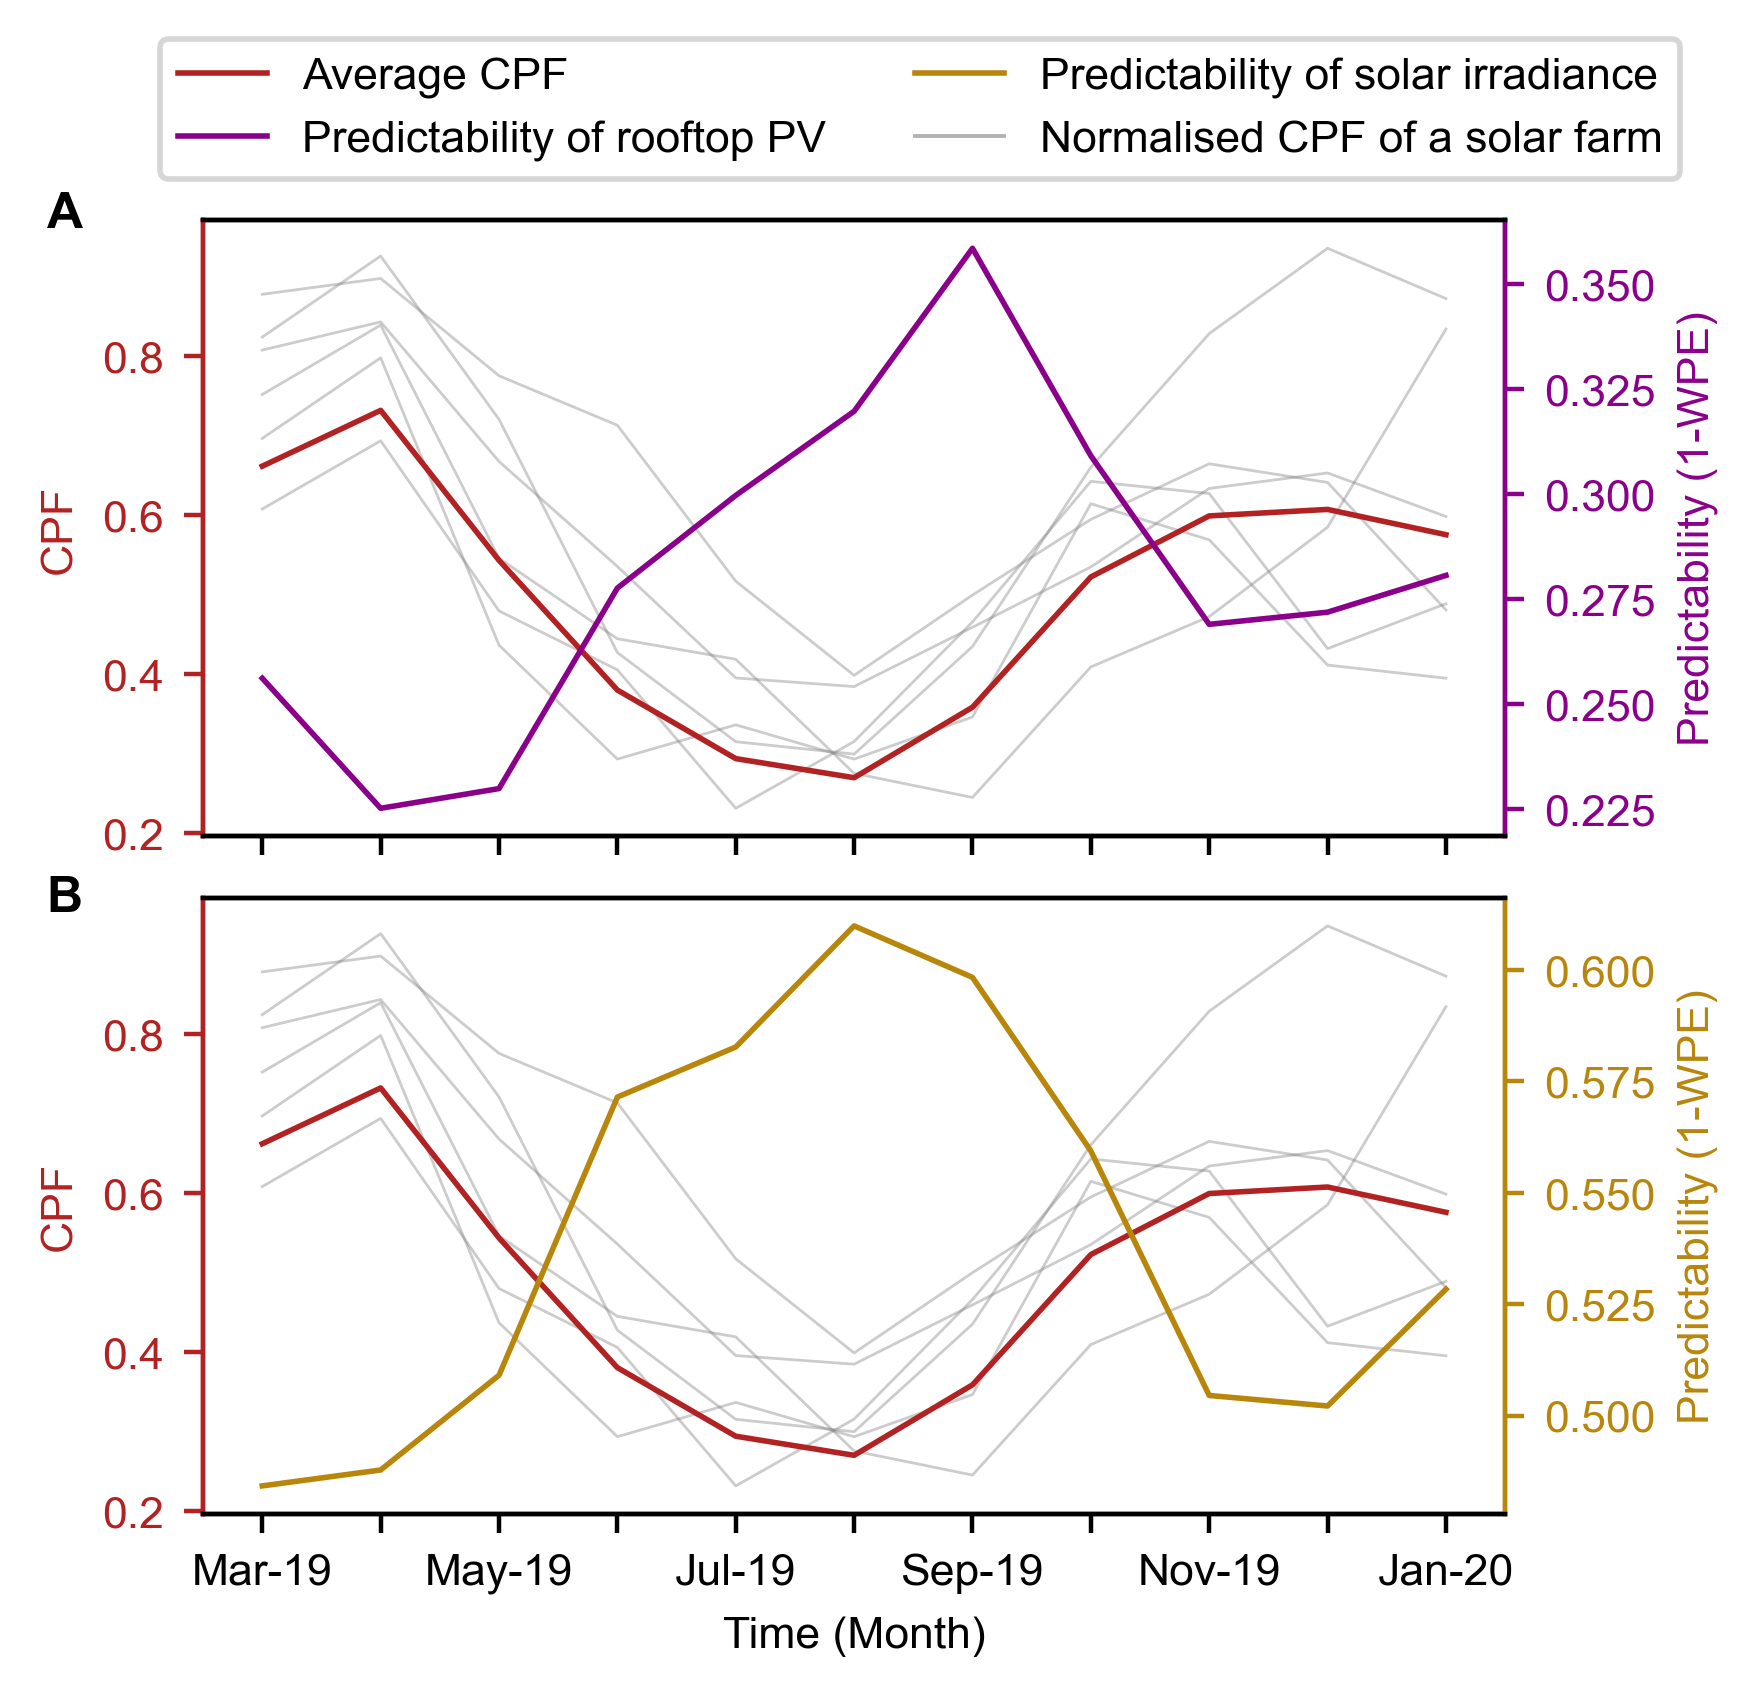

In [9]:
# Plotting Figure 6

plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

plt.figure(figsize=(4.2, 4.2))
plots = []

# first figure:
ax = plt.subplot2grid((2,1), (0,0))
ax.plot(cpf_df_ma['Manildra Solar Farm'][1:], linestyle='-', color = 'gray',  linewidth=0.5, alpha = 0.4)
ax.plot(cpf_df_ma['Mugga Lane Solar Park'][1:],  linestyle='-', color = 'gray',  linewidth=0.5, alpha = 0.4)
ax.plot(cpf_df_ma['Coleambally Solar Farm'][1:],  linestyle='-', color = 'gray',  linewidth=0.5, alpha = 0.4)
ax.plot(cpf_df_ma['Moree Solar Farm'][1:],  linestyle='-', color = 'gray',  linewidth=0.5, alpha = 0.4)
ax.plot(cpf_df_ma['Griffith Solar Farm Pty Ltd'][1:],  linestyle='-', color = 'gray',  linewidth=0.5, alpha = 0.4)
ax.plot(cpf_df_ma['Royalla Solar Farm Pty Limited'][1:],  linestyle='-', color = 'gray',  linewidth=0.5, alpha = 0.4)
ax.plot(mean_cpf_ma[1:],  linestyle='-', color = 'firebrick', label = "Average of all farms' CPF", linewidth = 1)
plt.xlabel('')
plt.ylabel("CPF",  color = 'firebrick')
ax.tick_params(axis='y', colors='firebrick')
ax2 = ax.twinx()
ax2.plot([wpe_rooftop_df.mean(axis=1)[((i-1)*30)] for i in list(range(1,12))], color = 'darkmagenta', linewidth = 1)
plt.ylabel("Predictability (1-WPE)",  color = 'darkmagenta')
ax2.tick_params(axis='y', colors='darkmagenta')

ax.axes.xaxis.set_ticklabels([])
plt.tick_params(axis='x', which='both', labelbottom=False)

ax.spines['right'].set_color('darkmagenta')
ax.spines['left'].set_color('firebrick')
ax2.spines['right'].set_color('darkmagenta')
ax2.spines['left'].set_color('firebrick')

# captions:
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(x0 - data_width * 0.12 , ymax - data_height * 0.012,'A', weight='bold',  fontsize=9)

# second figure:
ax = plt.subplot2grid((2,1), (1,0))
ax.plot(cpf_df_ma['Manildra Solar Farm'][1:], linestyle='-', color = 'gray', linewidth=0.5, alpha=0.4)
ax.plot(cpf_df_ma['Mugga Lane Solar Park'][1:], linestyle='-', color = 'gray', linewidth=0.5, alpha=0.4)
ax.plot(cpf_df_ma['Coleambally Solar Farm'][1:], linestyle='-', color = 'gray', linewidth=0.5, alpha=0.4)
ax.plot(cpf_df_ma['Moree Solar Farm'][1:], linestyle='-', color = 'gray', linewidth=0.5, alpha=0.4)
ax.plot(cpf_df_ma['Griffith Solar Farm Pty Ltd'][1:], linestyle='-', color = 'gray', linewidth=0.5, alpha=0.4)
ax.plot(cpf_df_ma['Royalla Solar Farm Pty Limited'][1:], linestyle='-', color = 'gray', linewidth=0.5, alpha=0.4)
ax.plot(mean_cpf_ma[1:],  linestyle='-', color = 'firebrick', label = "Average of all farms' CPF", linewidth = 1)

plt.xlabel('Time (Month)')
plt.ylabel("CPF", color = 'firebrick')
ax.tick_params(axis='y', colors='firebrick')
ax2 = ax.twinx()

ax2.plot([1 - weighted_solarfarm_wpe_ma[i] for i in list(range(0,11))], color = 'darkgoldenrod', linewidth = 1)
plt.ylabel("Predictability (1-WPE)", color = 'darkgoldenrod')
ax2.tick_params(axis='y', colors='darkgoldenrod')
ax.spines['right'].set_color('darkgoldenrod')
ax.spines['left'].set_color('firebrick')
ax2.spines['right'].set_color('darkgoldenrod')
ax2.spines['left'].set_color('firebrick')
ax.axes.xaxis.set_ticklabels(['Mar-19', '', 'May-19', '', 'Jul-19', '', 'Sep-19', '', 'Nov-19', '', 'Jan-20'])

# captions:
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(x0 - data_width * 0.12 , ymax - data_height * 0.022,'B', weight='bold',  fontsize=9)

legend_elements = [
    Line2D([0], [0], color='firebrick', lw=1, label='Average CPF'),
    Line2D([0], [0], color='darkmagenta', lw=1, label='Predictability of rooftop PV'),
    Line2D([0], [0], color='darkgoldenrod', lw=1, label='Predictability of solar irradiance'),
    Line2D([0], [0], color='grey', lw=0.7, alpha =0.6, label='Normalised CPF of a solar farm')]
plt.legend(handles=legend_elements, ncol = 2, loc =2, bbox_to_anchor=(-0.05, 2.43))
plt.subplots_adjust(wspace=0, hspace=0.1)

plt.savefig('Figure6.pdf', dpi = 400, bbox_inches='tight')

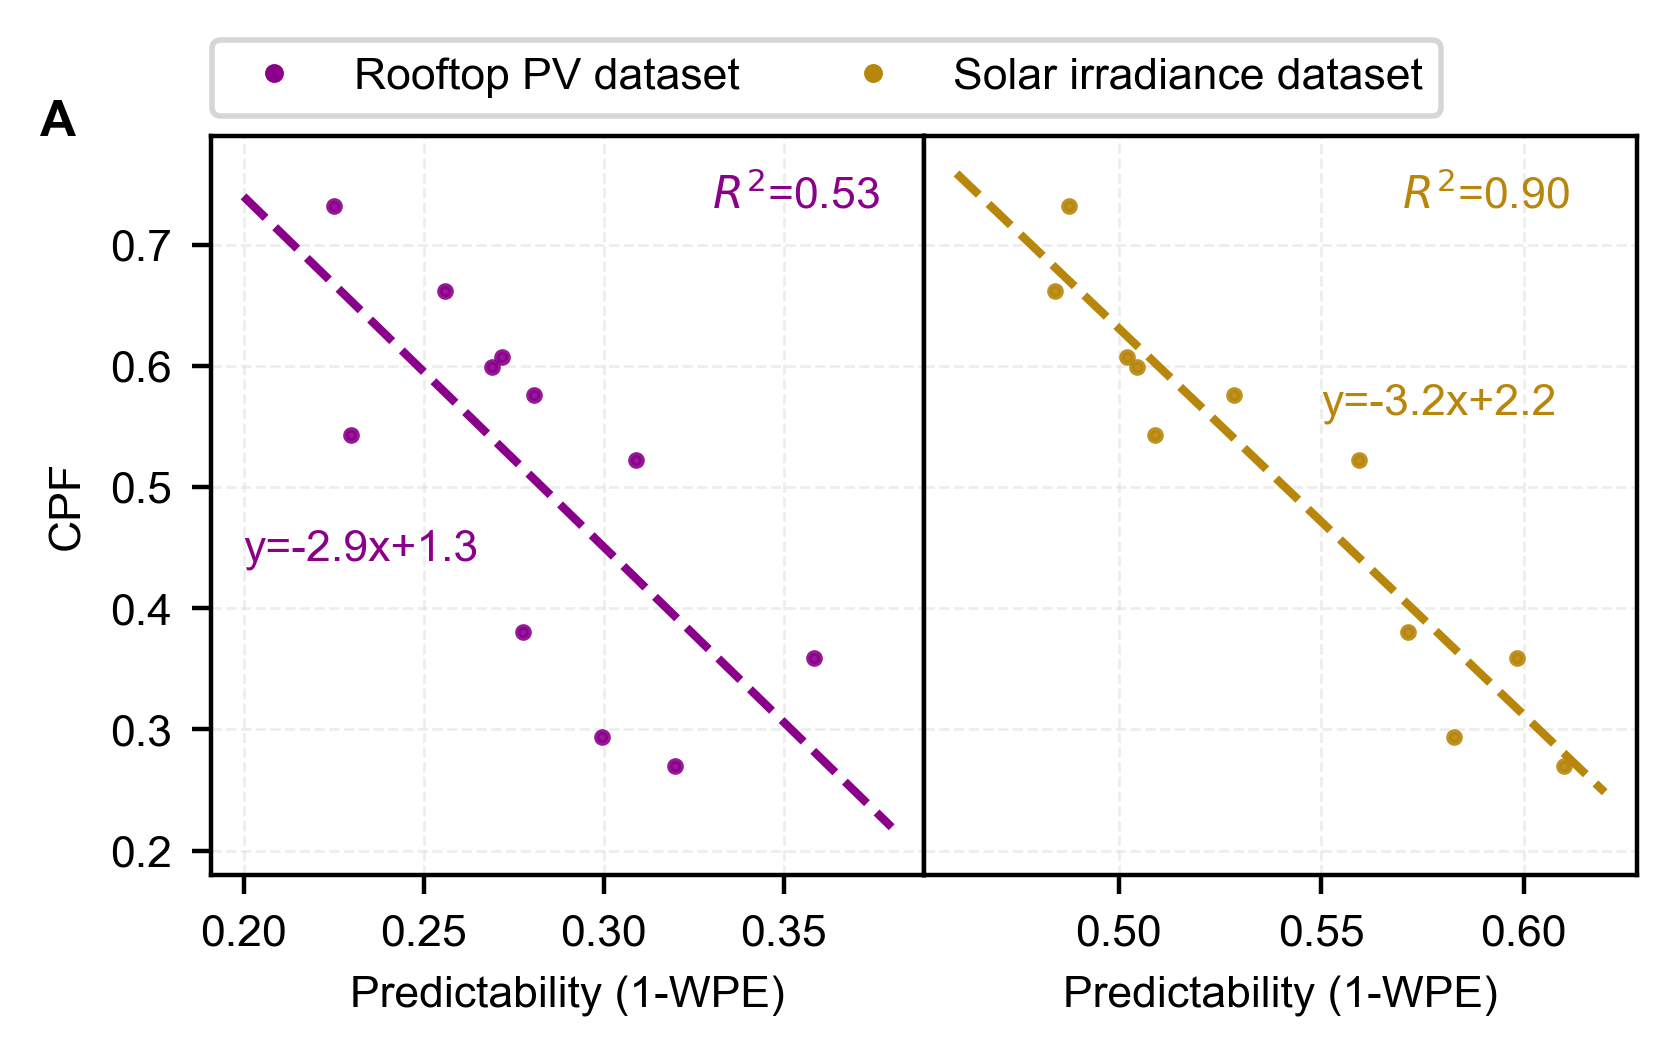

In [69]:
# Plotting Figure 7 (a)

plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

plt.figure(figsize=(4.6, 2.4))

# First figure:
ax = plt.subplot2grid((1,2), (0,0))
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 0.5, alpha = 0.5)

Y= mean_cpf_ma[1:].values.astype('float')
X= [wpe_rooftop_df.mean(axis=1)[((i-1)*30)] for i in list(range(1,12))]

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2).fit()

B = est.params[0]
A = est.params[1]
xx = np.linspace(0.2,0.38 ,100)
Regress = A*xx+B

plt.plot(X, Y, 'o', color = 'darkmagenta', markersize=2, alpha = 0.9)
plt.plot(xx, Regress, '--', color = 'darkmagenta',  alpha = 1)
plt.ylim([0.18, 0.79])
plt.text(0.33, 0.73, '$R^2$=%0.2f' % est.rsquared, color = 'darkmagenta')
plt.text(0.2, 0.44, 'y=' + str(round(A,1)) + 'x+' + str(round(B,1)) , color = 'darkmagenta')
plt.xlabel('Predictability (1-WPE)')
plt.ylabel('CPF')


# Second figure:
ax = plt.subplot2grid((1,2), (0,1))
ax.grid(color = 'gainsboro', linestyle = '--', linewidth = 0.5, alpha = 0.5)
Y= mean_cpf_ma[1:].values.astype('float')
X= [(1 - weighted_solarfarm_wpe_ma[i]) for i in list(range(0,11))]
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2).fit()
B = est.params[0]
A = est.params[1]
xx = np.linspace(0.46,0.62 ,100)
Regress = A*xx+B

plt.plot(X, Y, 'o', color = 'darkgoldenrod', markersize=2, alpha = 0.9)
plt.plot(xx, Regress, '--', color = 'darkgoldenrod',  alpha = 1)
plt.ylim([0.18, 0.79])
plt.text(0.57, 0.73, '$R^2$=%0.2f' % est.rsquared, color = 'darkgoldenrod')
plt.text(0.55, 0.56, 'y=' + str(round(A,1)) + 'x+' + str(round(B,1)) , color = 'darkgoldenrod')

plt.xlabel('Predictability (1-WPE)')
plt.ylabel('')
ax.axes.yaxis.set_ticklabels([])
plt.tick_params(axis='y', which='both',left=False)

legend_elements = [Line2D([0], [0], marker="o", markersize=3, color='darkmagenta', linewidth = 0, markeredgewidth = 0.4, alpha = 1,
                          markerfacecolor='darkmagenta', label='Rooftop PV dataset'),
                   Line2D([0], [0], marker="o", markersize=3, color='darkgoldenrod', linewidth = 0, markeredgewidth = 0.4, alpha = 1,
                          markerfacecolor='darkgoldenrod', label='Solar irradiance dataset')]

plt.legend(handles=legend_elements, ncol = 2, loc =2, bbox_to_anchor=(-1.03, 1.16))
plt.subplots_adjust(wspace=0, hspace=0)

# captions:
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(x0 - 1.24 * data_width , ymax ,'A', weight='bold',  fontsize=9)

plt.savefig('Figure7a.pdf', dpi = 400, bbox_inches='tight')

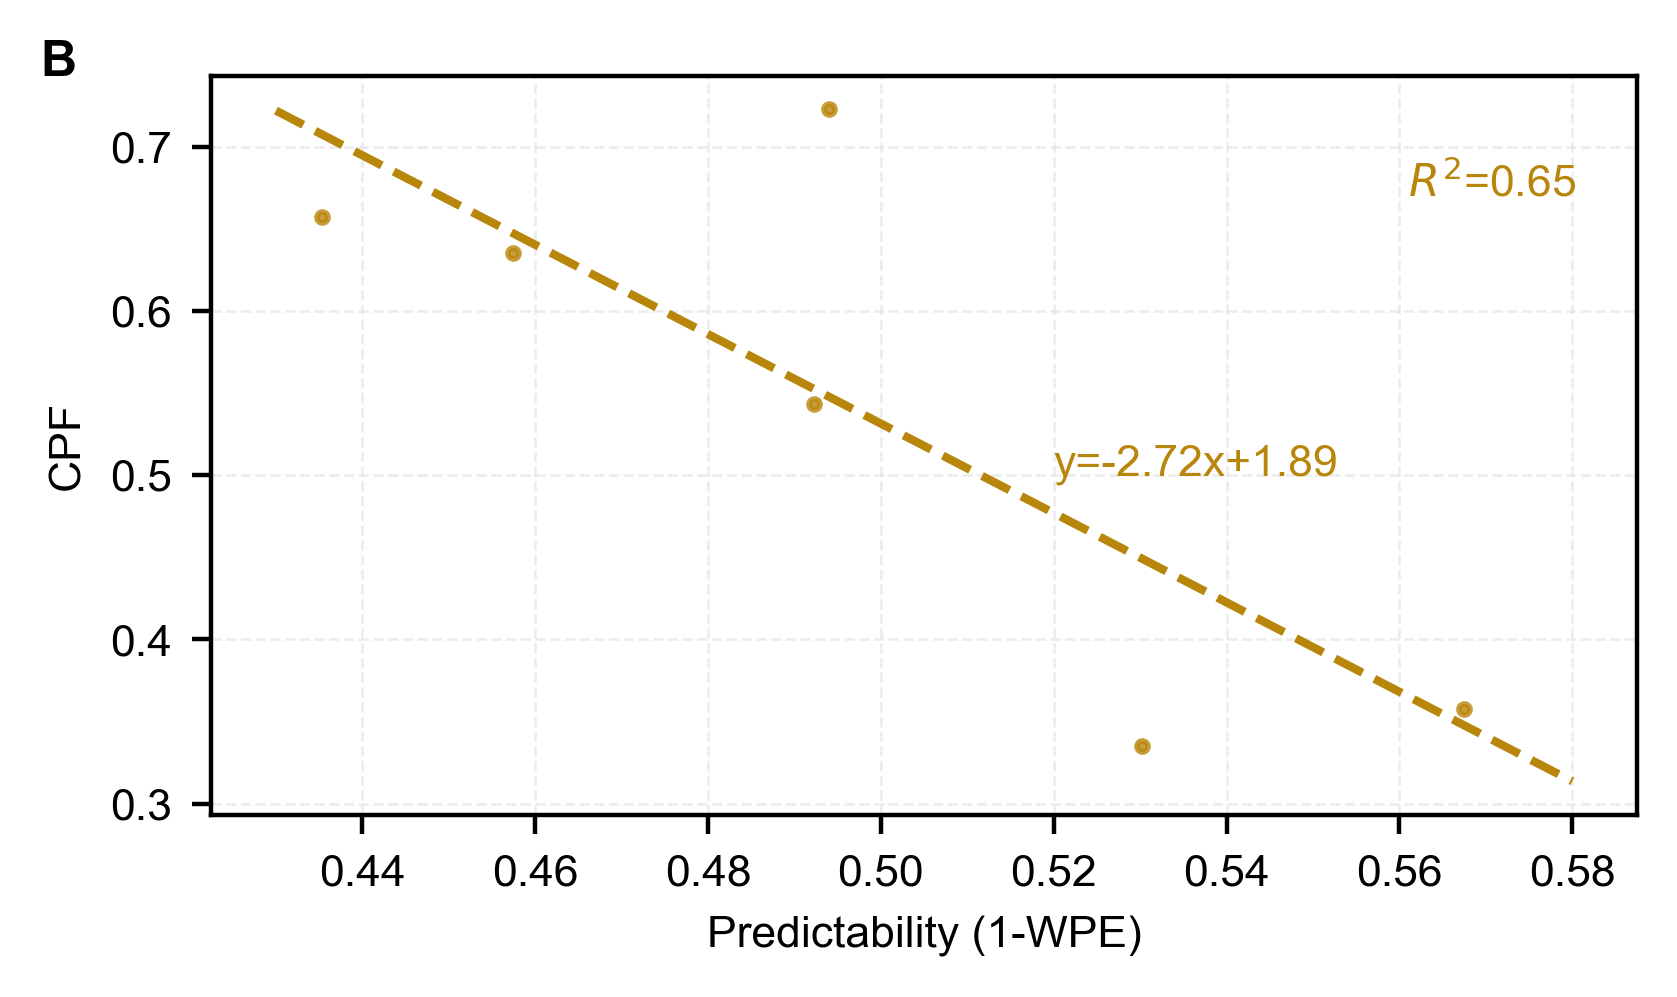

In [70]:
# Plotting Figure 7 (b)

plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 8
plt.rcParams['figure.dpi'] = 400
plt.rcParams['savefig.dpi'] = 400

plt.figure(figsize=(4.6, 2.4))


Y= sol_df['norm_avg_CPF'].astype('float')
X= [1-k for k in sol_df['WPE_of_GtiTracking'].astype('float')]

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2).fit()

B = est.params[0]
A = est.params[1]
xx = np.linspace(0.43,0.58 ,100)
Regress = A*xx+B

plt.plot(X, Y, 'o', color = 'darkgoldenrod', markersize=2, alpha = 0.8)

plt.plot(xx, Regress, '--', color = 'darkgoldenrod',  alpha = 1)
plt.grid(color = 'gainsboro', linestyle = '--', linewidth = 0.5, alpha = 0.5)
plt.text(0.561, 0.67, '$R^2$=%0.2f' % est.rsquared, color = 'darkgoldenrod')

plt.text(0.52, 0.5, 'y=' + str(round(A,2)) + 'x+' + str(round(B,2)) , color = 'darkgoldenrod')

plt.xlabel('Predictability (1-WPE)')
plt.ylabel('CPF')

# for captions:
x0, xmax = plt.xlim()
y0, ymax = plt.ylim()
data_width = xmax - x0
data_height = ymax - y0
plt.text(x0 - 0.12 * data_width , ymax ,'B', weight='bold',  fontsize=9)

plt.savefig('Figure7b.pdf', dpi = 400, bbox_inches='tight')